In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import relativedelta
import datetime

In [2]:
sns.set()

In [2]:
# Функция для предварительного анализа данных
def df_eda(df):
  class color:
    BLUE = '\033[94m'
    BOLD = '\033[1m'
    END = '\033[0m'
  
  def tbl_dict_base(df, col):
    tbl_dict = {}
    tbl_dict['valid'] = (~df[col].isnull()).sum()
    tbl_dict['valid_pct'] = tbl_dict['valid']/len(df)
    tbl_dict['missing'] = (df[col].isnull()).sum()
    tbl_dict['missing_pct'] = tbl_dict['missing']/len(df)
    tbl_dict['unique_values'] = df[col].nunique()
    return tbl_dict

  def display_table(tbl_dict, subset1=['missing', 'missing_pct'], \
                    subset2=['valid_pct', 'missing_pct']):
    tbl_det = pd.DataFrame([tbl_dict])
    tbl_det = (
        tbl_det.style.applymap(lambda x: 'color:red' if x > 0 else 'color:green', 
                              subset=subset1)
        .format('{:0.2%}', subset=subset2).hide(axis='index')
      )
    display(tbl_det)

  pd.set_option('display.max_columns', None)
  print(color.BOLD + 'General information' + color.END)
#   display(df.head())
#   print('')
  display(df.info())
  df_duples = df.copy()
  print('')

#   print(color.BOLD + 'Heatmap - missing values' + color.END)
#   fig, ax = plt.subplots(figsize=(8,5))
#   sns.heatmap(df.isna(), cmap='Blues', cbar=False)
#   plt.show();
  print('')
  print('')
  print(color.BOLD + 'Column stats' + color.END)
  print('')

  missing_cols_cnt = 0
  missing_cols_list = []
  id_duples = 0
  
  for col in df.columns:
    if df[col].dtype == 'object':
      print(color.BLUE + f'{col} - dtype: {df[col].dtype}' + color.END)
      tbl_dict = tbl_dict_base(df, col)
      try:
        df[col] = df[col].str.replace('ё','е')
        tbl_dict['case_sensitive_dupl'] = (
          df[col].str.lower().duplicated().sum() - df[col].duplicated().sum()
        )
        if tbl_dict['case_sensitive_dupl'] > 0:
          df_duples[col] = df_duples[col].str.lower()
        
        display_table(tbl_dict, ['missing', 'missing_pct', 'case_sensitive_dupl'])
      
      except:
        print('Dtype check needed')
        display_table(tbl_dict)
            
      if tbl_dict['missing'] > 0:
        missing_cols_cnt += 1
        missing_cols_list.append(col)

      if tbl_dict['unique_values'] > 5:
        most_common = df[col].value_counts(normalize=True).reset_index()
        most_common.columns=['Most common', col]
        most_common['Most common'] = (
            most_common['Most common']
            .where(most_common['Most common']
                  .isin(df[col].value_counts(normalize=True).head(5).index), 'other')
        )
        most_common = (
            most_common.groupby('Most common', sort=False)[col]
            .agg('sum').to_frame('')
        )

      else:
        most_common = df[col].value_counts(normalize=True).reset_index()
        most_common.columns=['Most common', '']
        most_common = most_common.set_index('Most common')
      
      display(most_common.style.format('{:0.1%}'))
      print('')

    elif df[col].dtype == 'float' or df[col].dtype == 'int64':
      print(color.BLUE + f'{col} - dtype: {df[col].dtype}' + color.END)
      tbl_dict = tbl_dict_base(df, col)
      tbl_dict['zeros'] = len(df[df[col] == 0])
      tbl_dict['negatives'] = len(df[df[col] < 0])
      display_table(tbl_dict)

      if tbl_dict['missing'] > 0:
        missing_cols_cnt += 1
        missing_cols_list.append(col)
      
      if tbl_dict['unique_values'] < 50:
        sns.histplot(df[col], bins=tbl_dict['unique_values'])
      elif tbl_dict['unique_values'] > 100:
        sns.histplot(df[col], bins=50)
      else:
        sns.histplot(df[col], bins=tbl_dict['unique_values']//2)
      plt.show();
      tbl_stats = pd.DataFrame({'':[df[col].mean(), df[col].median(), 
                                   df[col].std(), df[col].min(),
                                   df[col].max(), df[col].quantile(0.01),
                                   df[col].quantile(0.99)]})
      tbl_stats.index = ['mean', 'median', 'std', 'min', 'max', 
                         '1st quantile', '99th quantile']
      display(tbl_stats.style.format('{:.2f}'))
      # display(df[col].describe().to_frame('')[1:].style.format("{:.2f}"))
      print('')

    elif df[col].dtype == 'datetime64[ns]':
      print(color.BLUE + f'{col} - dtype: {df[col].dtype}' + color.END)
      tbl_dict = tbl_dict_base(df, col)
      display_table(tbl_dict)

      if tbl_dict['missing'] > 0:
        missing_cols_cnt += 1
        missing_cols_list.append(col)

      if tbl_dict['unique_values'] < 50:
        sns.histplot(df[col], bins=tbl_dict['unique_values'])
      elif tbl_dict['unique_values'] > 100:
        sns.histplot(df[col], bins=50)
      else:
        sns.histplot(df[col], bins=tbl_dict['unique_values']//2)
      plt.xticks(rotation=45)
      plt.show();
      display(df[col].apply(['min', 'max', 'mean']).to_frame(''))
      print('')

    elif df[col].dtype == 'bool':
      print(color.BLUE + f'{col} - dtype: {df[col].dtype}' + color.END)
      tbl_dict = tbl_dict_base(df, col)
      display_table(tbl_dict)
      display(df[col].value_counts(normalize=True).to_frame('').style.format('{:0.1%}'))
      
      if tbl_dict['missing'] > 0:
        missing_cols_cnt += 1
        missing_cols_list.append(col)
    
    else:
      print(color.BLUE + col + color.END)
      print('check format')

    if col.lower() == 'id' or col.lower() == 'userid' or col.lower() == 'user_id':
        id_duples = df[col].duplicated().sum()
  
  print(color.BLUE + 'EDA brief' + color.END)
  print('')
  print(f'Rows in dataset: {df.shape[0]}')
  print(f'Columns in dataset: {df.shape[1]}')
  print(f'Number of columns with missing values: {missing_cols_cnt}')
  print('Columns with missing values: ', missing_cols_list)
  print('')

  print(color.BOLD + 'Duplicates in dataset: ' + color.END)
  tbl_dupl = (
      pd.DataFrame({'duples_cnt':[df.duplicated().sum()], 
                    'duples_pct':[df.duplicated().sum()/len(df)],
                    'case_sensitive_duples':[(df_duples.duplicated().sum()-df.duplicated().sum())],
                    'case_sensitive_pct':[(df_duples.duplicated().sum()-df.duplicated().sum())/len(df)], 
                    'id_duples':[id_duples],
                    'id_duples_pct':[id_duples/len(df)]})
      .style.applymap(lambda x: 'color:red' if x > 0 else 'color:green')
      .format('{:.2%}', subset=['duples_pct', 'case_sensitive_pct', 'id_duples_pct'])
  )
  display(tbl_dupl)

In [3]:
cities = pd.read_excel('C:/Rabota/IT/Datasets/russian_cities.xlsx')

In [4]:
cities.head()

,city,region,federal_district,population
0,Абаза,Хакасия,Сибирский,17111
1,Абакан,Хакасия,Сибирский,165183
2,Абдулино,Оренбургская обл,Приволжский,20663
3,Абинск,Краснодарский край,Южный,34926
4,Агидель,Башкортостан,Приволжский,16365


In [3]:
df = pd.read_csv('C:/Rabota/IT/test_tasks/frame_2.csv')

In [4]:
df.head()

,Id,Город,Пол,Дата рождения,Дата отправки,Статус отправки,Название_письма
0,2,Мытищи,мужской,1964-02-24,2020-11-19 00:46:09,Открыто,Еженедельный Аналитический Дайджест
1,2,Мытищи,мужской,1964-02-24,2020-11-26 01:58:27,Открыто,Еженедельный Аналитический Дайджест
2,2,Мытищи,мужской,1964-02-24,2020-11-27 00:24:05,Отправлено,Еженедельный Аналитический Дайджест
3,2,Мытищи,мужской,1964-02-24,2020-12-03 02:21:10,Открыто,Еженедельный Аналитический Дайджест
4,2,Мытищи,мужской,1964-02-24,2020-12-04 00:46:05,Отправлено,Еженедельный Аналитический Дайджест


In [5]:
df['dob'] = pd.to_datetime(df['Дата рождения'], format='%Y-%m-%d')
df['sent_dt'] = pd.to_datetime(df['Дата отправки'], format='%Y-%m-%d %H:%M:%S')

General information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 359967 entries, 0 to 360126
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           359967 non-null  int64         
 1   locality     359967 non-null  object        
 2   gender       359967 non-null  object        
 3   dob_str      359967 non-null  object        
 4   sent_dt_str  359967 non-null  object        
 5   sent_status  359967 non-null  object        
 6   dob          359967 non-null  datetime64[ns]
 7   sent_dt      359967 non-null  datetime64[ns]
 8   age          359967 non-null  int64         
 9   flag         359967 non-null  int64         
 10  hour         359967 non-null  int32         
 11  month        359967 non-null  int32         
 12  weekday      359967 non-null  int64         
 13  weekday2     359967 non-null  object        
 14  date         359967 non-null  datetime64[ns]
dtypes: datetime64[

None




Column stats

id - dtype: int64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
359967,100.00%,0,0.00%,17734,0,0


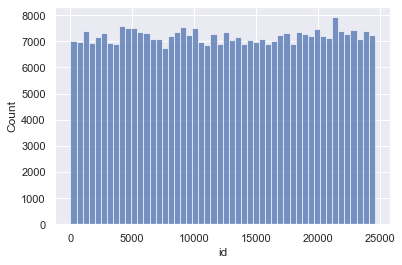

,
mean,12329.30
median,12315.00
std,7113.74
min,2.00
max,24584.00
1st quantile,255.00
99th quantile,24331.34



locality - dtype: object


valid,valid_pct,missing,missing_pct,unique_values,case_sensitive_dupl
359967,100.00%,0,0.00%,732,0


,
Most common,
Москва,20.5%
Санкт-Петербург,6.2%
Уфа,2.3%
Нижний Новгород,2.3%
Краснодар,2.3%
other,66.3%



gender - dtype: object


valid,valid_pct,missing,missing_pct,unique_values,case_sensitive_dupl
359967,100.00%,0,0.00%,2,0


,
Most common,
мужской,75.8%
женский,24.2%



dob_str - dtype: object


valid,valid_pct,missing,missing_pct,unique_values,case_sensitive_dupl
359967,100.00%,0,0.00%,10422,0


,
Most common,
1985-01-01,0.1%
1984-10-23,0.1%
1986-06-25,0.0%
1977-05-23,0.0%
1982-05-17,0.0%
other,99.7%



sent_dt_str - dtype: object


valid,valid_pct,missing,missing_pct,unique_values,case_sensitive_dupl
359967,100.00%,0,0.00%,85120,0


,
Most common,
2021-02-27 00:34:58,0.0%
2021-03-26 00:32:52,0.0%
2021-03-18 23:51:34,0.0%
2021-01-29 00:29:17,0.0%
2021-04-15 23:57:59,0.0%
other,100.0%



sent_status - dtype: object


valid,valid_pct,missing,missing_pct,unique_values,case_sensitive_dupl
359967,100.00%,0,0.00%,4,0


,
Most common,
Отправлено,73.6%
Открыто,24.3%
Переход по ссылке,1.9%
Не отправлено,0.2%



dob - dtype: datetime64[ns]


valid,valid_pct,missing,missing_pct,unique_values
359967,100.00%,0,0.00%,10422


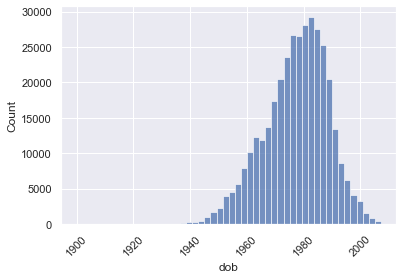

,
min,1899-12-31 00:00:00.000000000
max,2007-03-29 00:00:00.000000000
mean,1977-04-30 12:18:33.102034368



sent_dt - dtype: datetime64[ns]


valid,valid_pct,missing,missing_pct,unique_values
359967,100.00%,0,0.00%,85120


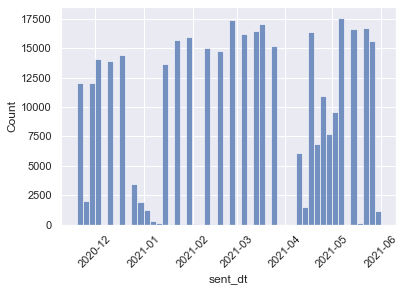

,
min,2020-11-19 00:10:37.000000000
max,2021-05-31 23:18:22.000000000
mean,2021-03-03 03:33:39.536912896



age - dtype: int64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
359967,100.00%,0,0.00%,76,0,0


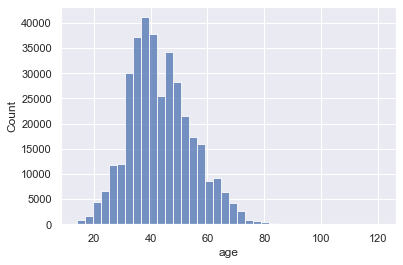

,
mean,43.34
median,42.00
std,11.18
min,14.00
max,121.00
1st quantile,21.00
99th quantile,72.00



flag - dtype: int64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
359967,100.00%,0,0.00%,2,265626,0


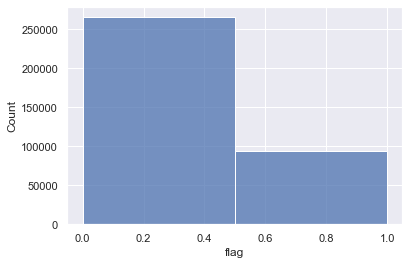

,
mean,0.26
median,0.00
std,0.44
min,0.00
max,1.00
1st quantile,0.00
99th quantile,1.00



hour
check format
month
check format
weekday - dtype: int64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
359967,100.00%,0,0.00%,7,308,0


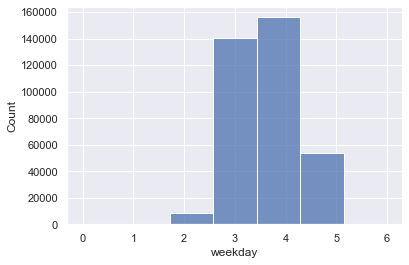

,
mean,3.71
median,4.00
std,0.76
min,0.00
max,6.00
1st quantile,2.00
99th quantile,5.00



weekday2 - dtype: object


valid,valid_pct,missing,missing_pct,unique_values,case_sensitive_dupl
359967,100.00%,0,0.00%,7,0


,
Most common,
Friday,43.4%
Thursday,39.0%
Saturday,15.0%
Wednesday,2.4%
Sunday,0.1%
other,0.2%



date - dtype: datetime64[ns]


valid,valid_pct,missing,missing_pct,unique_values
359967,100.00%,0,0.00%,123


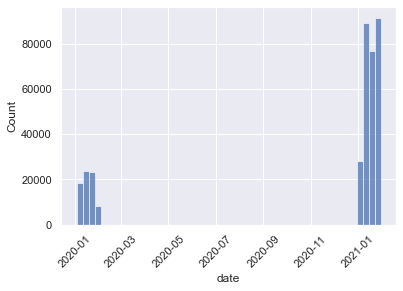

,
min,2020-01-03 00:12:00.000000000
max,2021-01-31 00:05:00.000000000
mean,2020-11-03 20:08:21.796998144



EDA brief

Rows in dataset: 359967
Columns in dataset: 15
Number of columns with missing values: 0
Columns with missing values:  []

Duplicates in dataset: 


,duples_cnt,duples_pct,case_sensitive_duples,case_sensitive_pct,id_duples,id_duples_pct
0,0,0.00%,0,0.00%,342233,95.07%


In [243]:
df_eda(df)

In [8]:
df.columns

Index(['Id', 'Город', 'Пол', 'Дата рождения', 'Дата отправки',
       'Статус отправки', 'Название_письма', 'dob', 'sent_dt'],
      dtype='object')

In [6]:
df.columns = ['id', 'locality', 'gender', 'dob_str', 'sent_dt_str', 'sent_status', 'letter_name', 'dob',
       'sent_dt']

In [7]:
df = df.drop_duplicates()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360118 entries, 0 to 360126
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           360118 non-null  int64         
 1   locality     360118 non-null  object        
 2   gender       360118 non-null  object        
 3   dob_str      359998 non-null  object        
 4   sent_dt_str  360118 non-null  object        
 5   sent_status  360087 non-null  object        
 6   letter_name  360118 non-null  object        
 7   dob          359998 non-null  datetime64[ns]
 8   sent_dt      360118 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 27.5+ MB


In [11]:
df.dropna(subset=['sent_status', 'dob'], inplace=True)

In [12]:
def age_in_years(row):
    rd = relativedelta.relativedelta(row['sent_dt'], row['dob'])
    return rd.years

In [13]:
df['age'] = df.apply(age_in_years, axis=1)

In [14]:
df['flag'] = [1 if x == 'Открыто' or x == 'Переход по ссылке' else 0 for x in df.sent_status]

In [15]:
df['locality'] = df['locality'].replace('крым', 'Крым')

In [16]:
readers_list = df.groupby('id')['flag'].agg(['count', 'mean']).query('mean > 0').index

In [19]:
readers = df.query('id in @readers_list').copy()

In [19]:
readers.columns

Index(['id', 'locality', 'gender', 'dob_str', 'sent_dt_str', 'sent_status',
       'letter_name', 'dob', 'sent_dt', 'age', 'flag'],
      dtype='object')

In [21]:
readers = readers.drop(['dob_str', 'sent_dt_str', 'letter_name'], axis=1)

In [20]:
readers['city'] = readers['locality'].str.split(',').str[0]

In [22]:
readers = readers.merge(cities, how='left', on='city')

In [23]:
readers['age_groups'] = pd.cut(readers['age'], bins=[0, 30, 40, 50, 60, float('inf')], 
           labels=['До 30', 'От 31 до 40', 'От 41 до 50', 'От 51 до 60', 'После 61'])

In [24]:
readers.groupby('age_groups')['id'].agg('nunique')

age_groups
До 30          1406
От 31 до 40    4431
От 41 до 50    4133
От 51 до 60    2213
После 61       1079
Name: id, dtype: int64

In [25]:
readers['population_groups'] = (
    pd.cut(readers['population'], \
           bins=[0, 50000, 100000, 250000, 1000000, float('inf')], \
           labels=['малый город', 'средний город', 'большой город', 'крупный город', 'миллионник'])
)

In [26]:
readers = readers.replace('женский', 'женщины')
readers = readers.replace('мужской', 'мужчины')

In [27]:
readers.head()

,id,locality,gender,sent_status,dob,sent_dt,age,flag,city,region,federal_district,population,age_groups,population_groups
0,2,Мытищи,мужчины,Открыто,1964-02-24,2020-11-19 00:46:09,56,1,Мытищи,Московская обл,Центральный,173341.0,От 51 до 60,большой город
1,2,Мытищи,мужчины,Открыто,1964-02-24,2020-11-26 01:58:27,56,1,Мытищи,Московская обл,Центральный,173341.0,От 51 до 60,большой город
2,2,Мытищи,мужчины,Отправлено,1964-02-24,2020-11-27 00:24:05,56,0,Мытищи,Московская обл,Центральный,173341.0,От 51 до 60,большой город
3,2,Мытищи,мужчины,Открыто,1964-02-24,2020-12-03 02:21:10,56,1,Мытищи,Московская обл,Центральный,173341.0,От 51 до 60,большой город
4,2,Мытищи,мужчины,Отправлено,1964-02-24,2020-12-04 00:46:05,56,0,Мытищи,Московская обл,Центральный,173341.0,От 51 до 60,большой город


In [36]:
readers_grouped = readers.groupby(['federal_district', 'region', 'population_groups', 'age_groups', 'gender'])['id'].agg('nunique').reset_index()

In [28]:
colors= ['#14D21E', '#14871E', '#AAAAAA', '#00B4D2', '#2D82A5','#FFBE1E', '#FFEB50', '#9B5028']
# '#0F4B0F'

In [62]:
genders = (
    readers.groupby('gender')
    .agg({'id':'nunique', 'flag':'mean'})
    .sort_values(by='flag', ascending=False)
    .reset_index()
)

In [63]:
genders

,gender,id,flag
0,мужчины,9406,0.325725
1,женщины,3342,0.294471


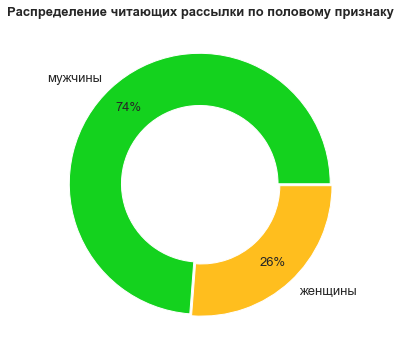

In [232]:
fig, ax = plt.subplots(figsize=(8,6))
labels = genders.gender
explode = (0.01, 0.01)
clrs=[colors[0], colors[5]]
genders.plot(kind='pie',
               x='gender',
               y='id',
               autopct='%1.0f%%',
               wedgeprops=dict(width=.4), 
               textprops={'size': 'large'},
               pctdistance=0.8, 
               labeldistance=1.1,
               colors=clrs, 
               labels=labels,
               explode=explode,
               legend=False,
               fontsize=13, 
               ax=ax).set(ylabel='')
# plt.legend(labels=labels, fontsize=12, loc='upper right', bbox_to_anchor=(1.1, 0.95))
plt.title('Распределение читающих рассылки по половому признаку', fontweight='bold', fontsize=13)
plt.show();

In [58]:
sns.set_style("whitegrid", {'axes.grid' : False})

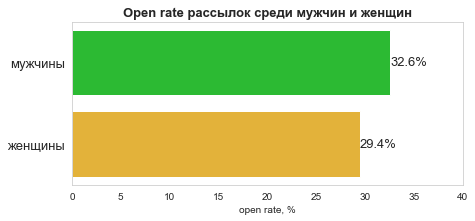

In [237]:
cols = [colors[0] if x == 'мужчины' else colors[5] for x in genders.gender]
ax, fig = plt.subplots(figsize=(7,3))
ax = sns.barplot(x=genders['flag']*100, y=genders['gender'], palette=cols)
ax.bar_label(ax.containers[0], fmt='%.1f%%', fontsize=13)
plt.title('Open rate рассылок среди мужчин и женщин', fontweight='bold', fontsize=13,)
plt.xlabel('open rate, %')
plt.ylabel('', fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(0,40)
plt.show();

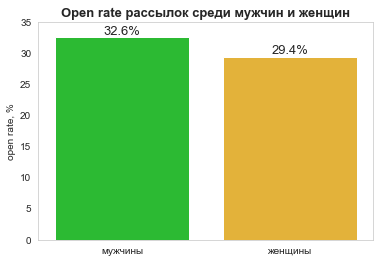

In [242]:
cols = [colors[0] if x == 'мужчины' else colors[5] for x in genders.gender]
ax, fig = plt.subplots(figsize=(6,4))
ax = sns.barplot(y=genders['flag']*100, x=genders['gender'], palette=cols)
ax.bar_label(ax.containers[0], fmt='%.1f%%', fontsize=13)
plt.title('Open rate рассылок среди мужчин и женщин', fontweight='bold', fontsize=13)
plt.ylabel('open rate, %')
plt.xlabel('', fontsize=13)
plt.ylim(0,35)
plt.show();

In [97]:
ages = (
    readers.groupby('age_groups')
    .agg({'id':'nunique', 'flag':'mean'})
    .sort_values(by='flag')
    .reset_index()
)

In [98]:
ages

,age_groups,id,flag
0,До 30,1406,0.264604
1,От 31 до 40,4431,0.292851
2,От 41 до 50,4133,0.319174
3,От 51 до 60,2213,0.368276
4,После 61,1079,0.369552


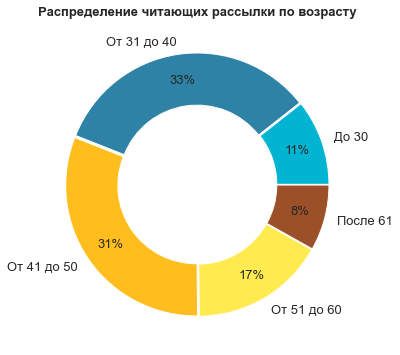

In [238]:
fig, ax = plt.subplots(figsize=(8,6))
labels = ages.age_groups
explode = (0.01, 0.01, 0.01, 0.01, 0.01)
ages.plot(kind='pie',
               x='age_groups', y='id',
               autopct='%1.0f%%',
               wedgeprops=dict(width=.4), 
               textprops={'size': 'medium'},
               pctdistance=0.8, 
               labeldistance=1.1,
               colors=colors[3:], fontsize=13,
               explode=explode, labels=labels,          
               legend=False,                
               ax=ax).set(ylabel='')
plt.title('Распределение читающих рассылки по возрасту', fontweight='bold', fontsize=13)
plt.show();

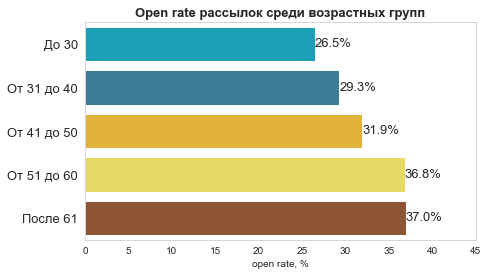

In [245]:
ax, fig = plt.subplots(figsize=(7,4))
ax = sns.barplot(x=ages['flag']*100, y=ages['age_groups'], palette=colors[3:])
ax.bar_label(ax.containers[0], fmt='%.1f%%', fontsize=13)
plt.title('Open rate рассылок среди возрастных групп', fontsize=13, fontweight='bold')
plt.xlabel('open rate, %')
plt.ylabel('')
plt.yticks(fontsize=13)
plt.xlim(0,45)
plt.show();

In [111]:
population = (
    readers.groupby('population_groups')
    .agg({'id':'nunique', 'flag':'mean'})
    .sort_values(by='flag', ascending=False)
    .reset_index()
)

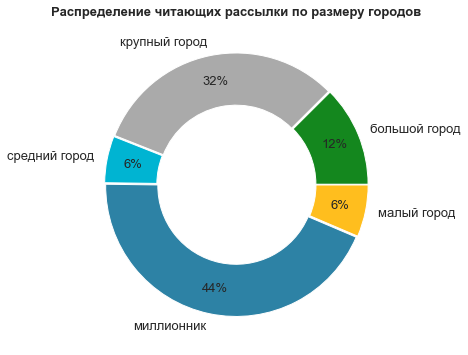

In [231]:
fig, ax = plt.subplots(figsize=(8,6))
labels = population.population_groups
explode = (0.01, 0.01, 0.01, 0.01, 0.01)
population.plot(kind='pie',
               x='population_groups', y='id',
               autopct='%1.0f%%',
               wedgeprops=dict(width=.4), 
               textprops={'size': 'medium'},
               pctdistance=0.8, 
               labeldistance=1.1,
               colors=colors[1:], 
               explode=explode, labels=labels,          
               legend=False, fontsize=13,               
               ax=ax).set(ylabel='')
plt.title('Распределение читающих рассылки по размеру городов', fontweight='bold', fontsize=13)
plt.show();

In [116]:
population.population_groups.values

['большой город', 'крупный город', 'средний город', 'миллионник', 'малый город']
Categories (5, object): ['малый город' < 'средний город' < 'большой город' < 'крупный город' < 'миллионник']

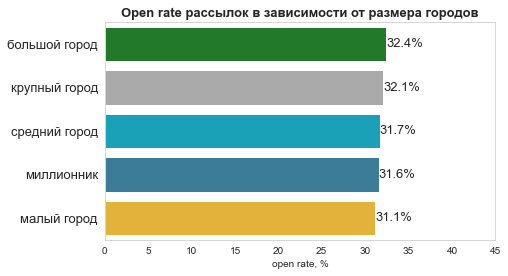

In [246]:
order=['большой город', 'крупный город', 'средний город', 'миллионник', 'малый город']
ax, fig = plt.subplots(figsize=(7,4))
ax = sns.barplot(x=population['flag']*100, y=population['population_groups'], palette=colors[1:], order=order)
ax.bar_label(ax.containers[0], fmt='%.1f%%', fontsize=13)
plt.title('Open rate рассылок в зависимости от размера городов', fontsize=13, fontweight='bold')
plt.xlabel('open rate, %')
plt.ylabel('')
plt.yticks(fontsize=13)
plt.xlim(0,45)
plt.show();

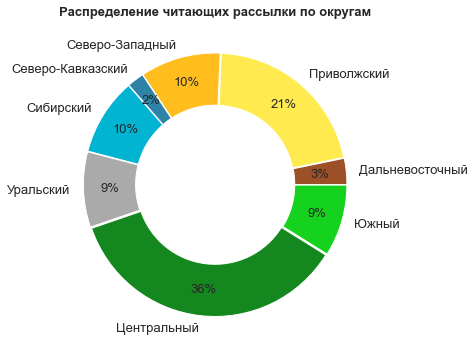

In [240]:
fig, ax = plt.subplots(figsize=(8,6))
labels = federal.federal_district
explode = (0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01)
federal.plot(kind='pie',
               x='federal_district', y='id',
               autopct='%1.0f%%',
               pctdistance=0.8, 
               labeldistance=1.1,
               wedgeprops=dict(width=.4), 
               textprops={'size': 'small'}, fontsize=13,
               colors=colors[::-1], legend=False,
               explode=explode, labels=labels,          
               ax=ax).set(ylabel='')
plt.title('Распределение читающих рассылки по округам', fontweight='bold', fontsize=13)
plt.show();

In [132]:
federal.sort_values(by='flag', ascending=False).federal_district.values

array(['Северо-Западный', 'Сибирский', 'Уральский', 'Центральный',
       'Приволжский', 'Южный', 'Дальневосточный', 'Северо-Кавказский'],
      dtype=object)

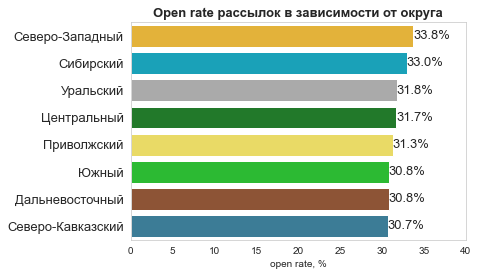

In [250]:
order=federal.sort_values(by='flag', ascending=False).federal_district.values
clrs = [colors[5], colors[3], colors[2],colors[1],colors[6],colors[0],colors[7],colors[4]]
ax, fig = plt.subplots(figsize=(6,4))
ax = sns.barplot(x=federal['flag']*100, y=federal['federal_district'], palette=clrs, order=order)
ax.bar_label(ax.containers[0], fmt='%.1f%%',fontsize=13)
plt.title('Open rate рассылок в зависимости от округа', fontsize=13, fontweight='bold')
plt.xlabel('open rate, %')
plt.ylabel('')
plt.yticks(fontsize=13)
plt.xlim(0,40)
plt.show();

In [34]:
localities = readers.groupby('city').agg({'id':'nunique'}).sort_values(by='id',ascending=False).head(10)

In [30]:
colors2= ['#14D21E', '#14871E', '#AAAAAA', '#00B4D2', '#2D82A5','#FFBE1E', '#FFEB50', '#9B5028', '#0F4B0F', '#A8A8A8']

In [33]:
readers.head()

,id,locality,gender,sent_status,dob,sent_dt,age,flag,city,region,federal_district,population,age_groups,population_groups
0,2,Мытищи,мужчины,Открыто,1964-02-24,2020-11-19 00:46:09,56,1,Мытищи,Московская обл,Центральный,173341.0,От 51 до 60,большой город
1,2,Мытищи,мужчины,Открыто,1964-02-24,2020-11-26 01:58:27,56,1,Мытищи,Московская обл,Центральный,173341.0,От 51 до 60,большой город
2,2,Мытищи,мужчины,Отправлено,1964-02-24,2020-11-27 00:24:05,56,0,Мытищи,Московская обл,Центральный,173341.0,От 51 до 60,большой город
3,2,Мытищи,мужчины,Открыто,1964-02-24,2020-12-03 02:21:10,56,1,Мытищи,Московская обл,Центральный,173341.0,От 51 до 60,большой город
4,2,Мытищи,мужчины,Отправлено,1964-02-24,2020-12-04 00:46:05,56,0,Мытищи,Московская обл,Центральный,173341.0,От 51 до 60,большой город


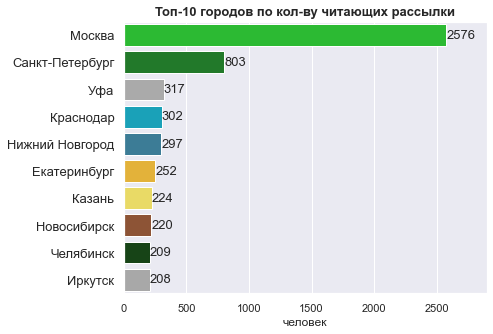

In [37]:
ax, fig = plt.subplots(figsize=(6.5,5))
ax = (
    sns.barplot(x=localities.id, 
                y=localities.index, 
                palette=colors2)
)
ax.bar_label(ax.containers[0], fmt='%.0f', fontsize=13)
plt.title('Топ-10 городов по кол-ву читающих рассылки', fontsize=13, fontweight='bold')
plt.xlabel('человек')
plt.ylabel('')
plt.yticks(fontsize=13)
plt.xlim(0,2900)
plt.show();

In [374]:
regions = (
    readers.groupby('region')
    .agg({'id':'nunique', 'flag':'mean'})
    .sort_values(by='id', ascending=False)
    .reset_index().head(10)
)

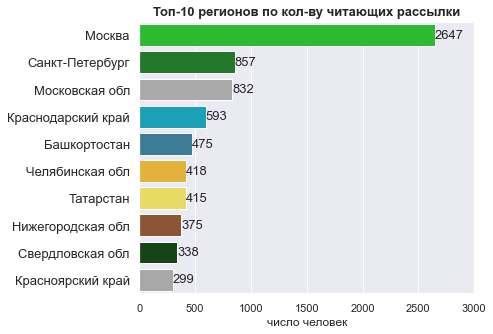

In [390]:
# order=federal.sort_values(by='flag', ascending=False).federal_district.values
ax, fig = plt.subplots(figsize=(6,5))
ax = sns.barplot(x=regions['id'], y=regions['region'], palette=colors2)
ax.bar_label(ax.containers[0], fmt='%.0f',fontsize=13)
plt.title('Топ-10 регионов по кол-ву читающих рассылки', fontsize=13, fontweight='bold')
plt.xlabel('число человек')
plt.ylabel('')
plt.yticks(fontsize=13)
plt.xlim(0,3000)
plt.show();

In [160]:
df = df.drop(['letter_name'], axis=1)

In [161]:
df.head()

,id,locality,gender,dob_str,sent_dt_str,sent_status,dob,sent_dt,age,flag
0,2,Мытищи,мужской,1964-02-24,2020-11-19 00:46:09,Открыто,1964-02-24,2020-11-19 00:46:09,56,1
1,2,Мытищи,мужской,1964-02-24,2020-11-26 01:58:27,Открыто,1964-02-24,2020-11-26 01:58:27,56,1
2,2,Мытищи,мужской,1964-02-24,2020-11-27 00:24:05,Отправлено,1964-02-24,2020-11-27 00:24:05,56,0
3,2,Мытищи,мужской,1964-02-24,2020-12-03 02:21:10,Открыто,1964-02-24,2020-12-03 02:21:10,56,1
4,2,Мытищи,мужской,1964-02-24,2020-12-04 00:46:05,Отправлено,1964-02-24,2020-12-04 00:46:05,56,0


In [162]:
df.sent_dt.apply(['min', 'max'])

min   2020-11-19 00:10:37
max   2021-05-31 23:18:22
Name: sent_dt, dtype: datetime64[ns]

In [163]:
df['hour'] = df['sent_dt_str'].str[11:13]

In [164]:
df['month'] = df['sent_dt_str'].str[5:7]

In [302]:
df.head()

,id,locality,gender,dob_str,sent_dt_str,sent_status,dob,sent_dt,age,flag,hour,month,weekday,date
0,2,Мытищи,мужской,1964-02-24,2020-11-19 00:46:09,Открыто,1964-02-24,2020-11-19 00:46:09,56,1,24,11,Thursday,2020-11-19
1,2,Мытищи,мужской,1964-02-24,2020-11-26 01:58:27,Открыто,1964-02-24,2020-11-26 01:58:27,56,1,01,11,Thursday,2020-11-26
2,2,Мытищи,мужской,1964-02-24,2020-11-27 00:24:05,Отправлено,1964-02-24,2020-11-27 00:24:05,56,0,24,11,Friday,2020-11-27
3,2,Мытищи,мужской,1964-02-24,2020-12-03 02:21:10,Открыто,1964-02-24,2020-12-03 02:21:10,56,1,02,12,Thursday,2020-12-03
4,2,Мытищи,мужской,1964-02-24,2020-12-04 00:46:05,Отправлено,1964-02-24,2020-12-04 00:46:05,56,0,24,12,Friday,2020-12-04


In [207]:
df['date'] = df['sent_dt'].dt.date
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [165]:
df['weekday'] = pd.Series(df.sent_dt).dt.day_name()

In [180]:
df['hour'] = df['hour'].replace('00', '24')

In [181]:
hours = df.groupby('hour')['flag'].agg(['count', 'mean']).reset_index()

In [182]:
hours

,hour,count,mean
0,01,7712,1.000000
1,02,8921,1.000000
2,03,80,1.000000
3,05,3,1.000000
4,09,13,1.000000
5,10,1619,1.000000
6,11,1167,1.000000
7,12,148,1.000000
8,13,1631,1.000000
9,14,1405,1.000000


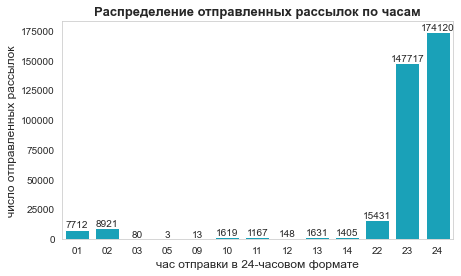

In [264]:
ax, fig = plt.subplots(figsize=(7,4))
ax = sns.barplot(y=hours['count'], x=hours['hour'], color=colors[3])
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.title('Распределение отправленных рассылок по часам', fontsize=13, fontweight='bold')
plt.ylabel('число отправленных рассылок', fontsize=12)
plt.xlabel('час отправки в 24-часовом формате', fontsize=12)
# plt.ylim(0,35)
plt.show();

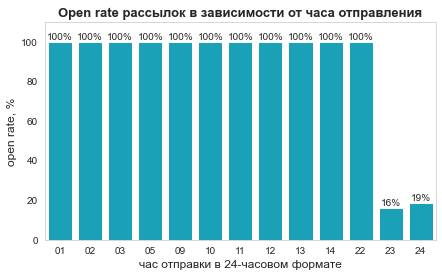

In [265]:
ax, fig = plt.subplots(figsize=(7,4))
ax = sns.barplot(y=hours['mean']*100, x=hours['hour'], color=colors[3])
ax.bar_label(ax.containers[0], fmt='%.0f%%')
plt.title('Open rate рассылок в зависимости от часа отправления', fontsize=13, fontweight='bold')
plt.ylabel('open rate, %', fontsize=12)
plt.xlabel('час отправки в 24-часовом формате', fontsize=12)
plt.ylim(0,110)
plt.show();

In [188]:
weekdays = df.groupby('weekday')['flag'].agg(['count', 'mean']).reset_index()

In [191]:
weekdays.weekday.values

array(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'], dtype=object)

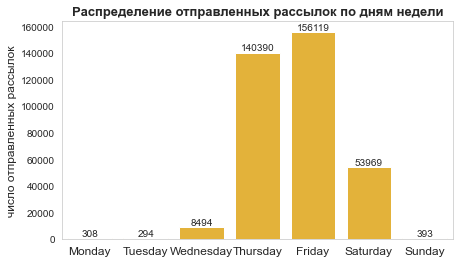

In [262]:
order = ['Monday','Tuesday','Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday']
ax, fig = plt.subplots(figsize=(7,4))
ax = sns.barplot(y=weekdays['count'], x=weekdays['weekday'], color=colors[5], order=order)
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.title('Распределение отправленных рассылок по дням недели', fontsize=13, fontweight='bold')
plt.ylabel('число отправленных рассылок', fontsize=12)
plt.xlabel('')
plt.xticks(fontsize=12)
# plt.ylim(0,35)
plt.show();

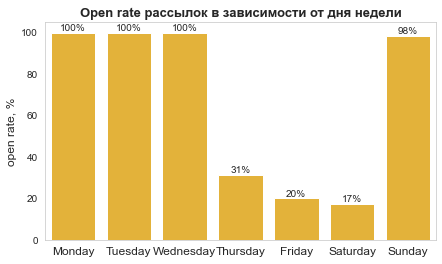

In [263]:
order = ['Monday','Tuesday','Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday']
ax, fig = plt.subplots(figsize=(7,4))
ax = sns.barplot(y=weekdays['mean']*100, x=weekdays['weekday'], color=colors[5], order=order)
ax.bar_label(ax.containers[0], fmt='%.0f%%')
plt.title('Open rate рассылок в зависимости от дня недели', fontsize=13, fontweight='bold')
plt.ylabel('open rate, %', fontsize=12)
plt.xlabel('')
plt.xticks(fontsize=12)
# plt.ylim(0,35)
plt.show();

In [303]:
months = df.groupby('month')['flag'].agg(['count', 'mean']).reset_index()

In [344]:
months

,month,count,mean
0,01,46983,0.299427
1,02,47156,0.237361
2,03,64952,0.228061
3,04,57229,0.298083
4,05,69780,0.201806
5,11,26105,0.262364
6,12,47762,0.340794


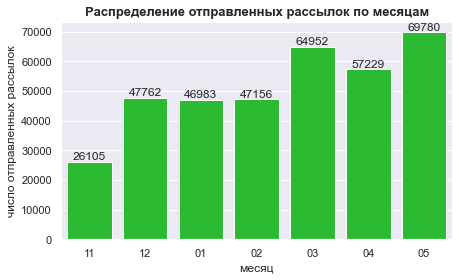

In [312]:
order = ['11','12','01', '02','03', '04', '05']
ax, fig = plt.subplots(figsize=(7,4))
ax = sns.barplot(y=months['count'], x=months['month'], color=colors[0], order=order)
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.title('Распределение отправленных рассылок по месяцам', fontsize=13, fontweight='bold')
plt.ylabel('число отправленных рассылок', fontsize=12)
plt.xlabel('месяц', fontsize=12)
# plt.ylim(0,35)
plt.show();

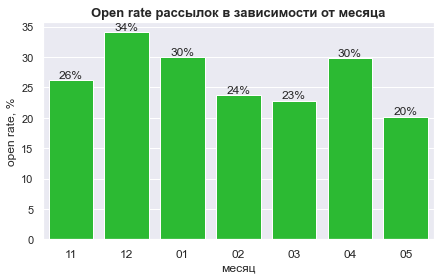

In [313]:
order = ['11','12','01', '02','03', '04', '05']
ax, fig = plt.subplots(figsize=(7,4))
ax = sns.barplot(y=months['mean']*100, x=months['month'], color=colors[0], order=order)
ax.bar_label(ax.containers[0], fmt='%.0f%%')
plt.title('Open rate рассылок в зависимости от месяца', fontsize=13, fontweight='bold')
plt.ylabel('open rate, %', fontsize=12)
plt.xlabel('месяц')
plt.xticks(fontsize=12)
# plt.ylim(0,35)
plt.show();

In [299]:
dates_flag = df.groupby('date')['flag'].agg(['count', 'mean']).reset_index()

In [300]:
dates_flag

,date,count,mean
0,2020-11-19,12000,0.270500
1,2020-11-26,7795,0.353560
2,2020-11-27,6310,0.134231
3,2020-12-03,1912,1.000000
4,2020-12-04,12148,0.160520
...,...,...,...
118,2021-05-26,166,1.000000
119,2021-05-27,15280,0.206937
120,2021-05-28,1366,0.035139
121,2021-05-30,2,0.500000


In [224]:
dates_flag.query('mean == 1').sort_values(by='count', ascending=False).head(10)

,date,count,mean
78,2021-04-10,6049,1.0
10,2020-12-24,2160,1.0
3,2020-12-03,1912,1.0
37,2021-01-20,1911,1.0
43,2021-01-27,1844,1.0
17,2020-12-31,1789,1.0
103,2021-05-06,1740,1.0
89,2021-04-21,1618,1.0
63,2021-02-24,1354,1.0
82,2021-04-14,1315,1.0


<AxesSubplot:xlabel='date', ylabel='mean'>

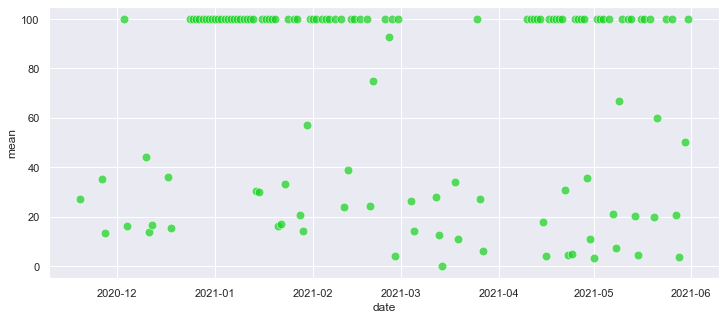

In [301]:
ax, fig = plt.subplots(figsize=(12,5))
sns.scatterplot(x=dates_flag['date'], y=dates_flag['mean']*100, s=75, color=colors[0], alpha=0.7)

In [225]:
t = df.groupby(['date', 'flag'])['sent_dt'].agg('count').reset_index()

In [272]:
def open_flag(x):
    if x == 0:
        return "не открыто"
    else:
        return "открыто"

In [276]:
t['flag'] = t['flag'].apply(open_flag)

In [286]:
t = df.pivot_table(index='date', columns='flag', values='sent_dt', aggfunc='count').reset_index()

In [266]:
sns.set()

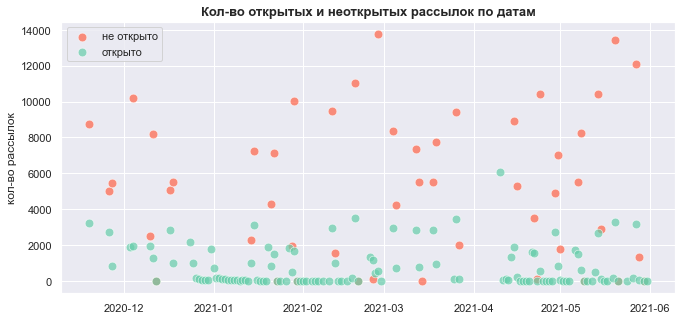

In [290]:
ax, fig = plt.subplots(figsize=(11,5))
sns.scatterplot(x=t['date'], y=t['не открыто'], color='tomato', s=75, alpha=0.7)
sns.scatterplot(x=t['date'], y=t['открыто'], color='mediumaquamarine', s=75, alpha=0.7)
plt.title('Кол-во открытых и неоткрытых рассылок по датам', fontsize=13, fontweight='bold')
plt.legend(['не открыто', 'открыто'])
plt.xlabel('')
plt.ylabel('кол-во рассылок')
plt.show();

In [294]:
t[t['открыто'] > t['не открыто']]

flag,date,не открыто,открыто
3,2020-12-03,0.0,1912.0
10,2020-12-24,0.0,2160.0
11,2020-12-25,0.0,987.0
12,2020-12-26,0.0,183.0
13,2020-12-27,0.0,93.0
...,...,...,...
114,2021-05-19,0.0,142.0
116,2021-05-21,2.0,3.0
117,2021-05-24,0.0,1.0
118,2021-05-26,0.0,166.0


In [293]:
t['не открыто'] = t['не открыто'].fillna(0)
t['открыто'] = t['открыто'].fillna(0)

In [295]:
t.query('date == "2021-04-10"')

flag,date,не открыто,открыто
78,2021-04-10,0.0,6049.0


In [317]:
readers = readers.drop('city', axis=1)

In [319]:
readers = readers.drop('population', axis=1)

In [322]:
readers = readers.merge(df[['sent_dt', 'hour', 'month', 'weekday']], how='left', on='sent_dt')

In [323]:
readers.head()

,id,locality,gender,sent_status,dob,sent_dt,age,flag,region,federal_district,age_groups,population_groups,hour,month,weekday
0,2,Мытищи,мужчины,Открыто,1964-02-24,2020-11-19 00:46:09,56,1,Московская обл,Центральный,От 51 до 60,большой город,24,11,Thursday
1,2,Мытищи,мужчины,Открыто,1964-02-24,2020-11-19 00:46:09,56,1,Московская обл,Центральный,От 51 до 60,большой город,24,11,Thursday
2,2,Мытищи,мужчины,Открыто,1964-02-24,2020-11-19 00:46:09,56,1,Московская обл,Центральный,От 51 до 60,большой город,24,11,Thursday
3,2,Мытищи,мужчины,Открыто,1964-02-24,2020-11-26 01:58:27,56,1,Московская обл,Центральный,От 51 до 60,большой город,01,11,Thursday
4,2,Мытищи,мужчины,Открыто,1964-02-24,2020-11-26 01:58:27,56,1,Московская обл,Центральный,От 51 до 60,большой город,01,11,Thursday


In [420]:
region_weekdays = (
    readers.query('flag == 1')
    .groupby(['region', 'weekday'])['sent_dt']
    .agg('count').reset_index()
    .sort_values(by=['region', 'sent_dt'], ascending=False).reset_index()
    .groupby('region').agg({'weekday':'first', 'sent_dt':'max'}).reset_index()
)

In [426]:
region_weekdays.query('weekday == "Friday"')

,region,weekday,sent_dt
2,Алтайский край,Friday,1350
3,Амурская обл,Friday,1134
4,Архангельская обл,Friday,554
5,Астраханская обл,Friday,356
7,Белгородская обл,Friday,1807
10,Владимирская обл,Friday,1232
11,Волгоградская обл,Friday,1948
12,Вологодская обл,Friday,1602
14,Дагестан,Friday,125
15,Еврейская Аобл,Friday,51


In [342]:
readers.query('federal_district == "Сибирский"').groupby('month')['flag'].agg(['count', 'mean'])

,count,mean
month,,
01,21621,0.325748
02,23557,0.249862
03,34246,0.262921
04,25620,0.194575
05,33097,0.178687
11,10032,0.319876
12,16916,0.337609


In [343]:
readers.groupby('month')['flag'].agg(['count', 'mean'])

,count,mean
month,,
01,235794,0.297103
02,254792,0.240573
03,374389,0.230672
04,272595,0.185612
05,346476,0.165203
11,111628,0.294380
12,189273,0.306409


В Москве доля женщин 30%, в Питере - 26%

In [353]:
gender_grouped = readers.pivot_table(index='region', columns='gender', values='id', aggfunc='nunique').reset_index()

In [355]:
gender_grouped['женщины'] = gender_grouped['женщины'].fillna(0)
gender_grouped['мужчины'] = gender_grouped['мужчины'].fillna(0)

In [356]:
gender_grouped['total'] = gender_grouped['женщины'] + gender_grouped['мужчины']

In [358]:
gender_grouped['women_pct'] = gender_grouped['женщины']/gender_grouped['total']

In [361]:
gender_grouped.query('women_pct > 0.26').sort_values(by='women_pct', ascending=False).head(10)

gender,region,женщины,мужчины,total,women_pct
71,Тыва,2.0,0.0,2.0,1.000000
43,Ненецкий АО,2.0,1.0,3.0,0.666667
54,Республика Саха,9.0,8.0,17.0,0.529412
9,Бурятия,11.0,13.0,24.0,0.458333
0,Адыгея,3.0,4.0,7.0,0.428571
5,Астраханская обл,9.0,12.0,21.0,0.428571
19,Кабардино-Балкария,3.0,4.0,7.0,0.428571
16,Забайкальский край,5.0,7.0,12.0,0.416667
21,Калмыкия,2.0,3.0,5.0,0.400000
49,Орловская обл,4.0,7.0,11.0,0.363636


In [398]:
top10 = regions.region.values

In [402]:
gender_top = gender_grouped.query('region in @top10').sort_values(by='total', ascending=False).reset_index()

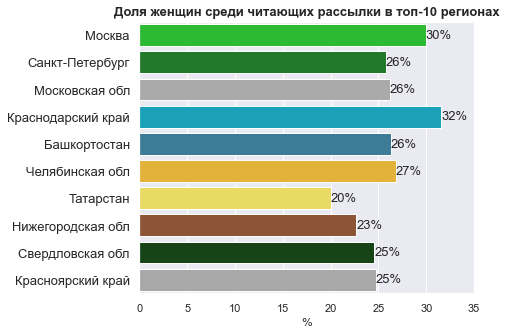

In [405]:
ax, fig = plt.subplots(figsize=(6,5))
ax = sns.barplot(x=gender_top['women_pct']*100, y=gender_top['region'], palette=colors2)
ax.bar_label(ax.containers[0], fmt='%.0f%%',fontsize=13)
plt.title('Доля женщин среди читающих рассылки в топ-10 регионах', fontsize=13, fontweight='bold')
plt.xlabel('%')
plt.ylabel('')
plt.yticks(fontsize=13)
plt.xlim(0,35)
plt.show();

In [368]:
gender_grouped.query('women_pct == 0')

gender,region,женщины,мужчины,total,women_pct
1,Алтай,0.0,2.0,2.0,0.0
24,Карачаево-Черкессия,0.0,6.0,6.0,0.0
33,Курганская обл,0.0,13.0,13.0,0.0
81,Чукотский АО,0.0,1.0,1.0,0.0


In [367]:
gender_grouped.query('total < 10').sort_values(by='total', ascending=False)

gender,region,женщины,мужчины,total,women_pct
0,Адыгея,3.0,4.0,7.0,0.428571
19,Кабардино-Балкария,3.0,4.0,7.0,0.428571
24,Карачаево-Черкессия,0.0,6.0,6.0,0.000000
79,Чечня,1.0,5.0,6.0,0.166667
21,Калмыкия,2.0,3.0,5.0,0.400000
15,Еврейская Аобл,1.0,3.0,4.0,0.250000
37,Магаданская обл,1.0,3.0,4.0,0.250000
43,Ненецкий АО,2.0,1.0,3.0,0.666667
1,Алтай,0.0,2.0,2.0,0.000000
71,Тыва,2.0,0.0,2.0,1.000000


In [389]:
readers.query('region == "Ненецкий АО"')

,id,locality,gender,sent_status,dob,sent_dt,age,flag,region,federal_district,age_groups,population_groups,hour,month,weekday
153514,2182,Нарьян-Мар,мужчины,Отправлено,1985-07-21,2021-01-22 00:06:00,35,0,Ненецкий АО,Северо-Западный,От 31 до 40,малый город,24,01,Friday
153515,2182,Нарьян-Мар,мужчины,Отправлено,1985-07-21,2021-01-22 00:06:00,35,0,Ненецкий АО,Северо-Западный,От 31 до 40,малый город,24,01,Friday
153516,2182,Нарьян-Мар,мужчины,Отправлено,1985-07-21,2021-01-22 00:06:00,35,0,Ненецкий АО,Северо-Западный,От 31 до 40,малый город,24,01,Friday
153517,2182,Нарьян-Мар,мужчины,Отправлено,1985-07-21,2021-01-22 00:06:00,35,0,Ненецкий АО,Северо-Западный,От 31 до 40,малый город,24,01,Friday
153518,2182,Нарьян-Мар,мужчины,Отправлено,1985-07-21,2021-01-28 23:55:10,35,0,Ненецкий АО,Северо-Западный,От 31 до 40,малый город,23,01,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558272,21577,Нарьян-Мар,женщины,Отправлено,1976-07-29,2021-05-27 23:51:47,44,0,Ненецкий АО,Северо-Западный,От 41 до 50,малый город,23,05,Thursday
1558273,21577,Нарьян-Мар,женщины,Отправлено,1976-07-29,2021-05-27 23:51:47,44,0,Ненецкий АО,Северо-Западный,От 41 до 50,малый город,23,05,Thursday
1558274,21577,Нарьян-Мар,женщины,Отправлено,1976-07-29,2021-05-27 23:51:47,44,0,Ненецкий АО,Северо-Западный,От 41 до 50,малый город,23,05,Thursday
1558275,21577,Нарьян-Мар,женщины,Отправлено,1976-07-29,2021-05-27 23:51:47,44,0,Ненецкий АО,Северо-Западный,От 41 до 50,малый город,23,05,Thursday


In [393]:
moscow_gender = readers.query('region == "Москва"').groupby('gender')['id'].agg('nunique')

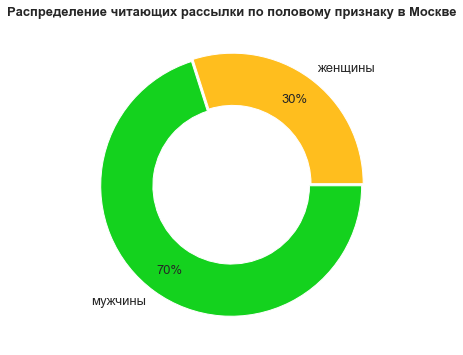

In [395]:
fig, ax = plt.subplots(figsize=(8,6))
labels = moscow_gender.index
explode = (0.01, 0.01)
clrs=[colors[5], colors[0]]
moscow_gender.plot(kind='pie',
               y='id',
               autopct='%1.0f%%',
               wedgeprops=dict(width=.4), 
               textprops={'size': 'large'},
               pctdistance=0.8, 
               labeldistance=1.1,
               colors=clrs, 
               labels=labels,
               explode=explode,
               legend=False,
               fontsize=13, 
               ax=ax).set(ylabel='')

plt.title('Распределение читающих рассылки по половому признаку в Москве', fontweight='bold', fontsize=13)
plt.show();